# Performance plots for computational costs of synthesis pipeline

## Author(s): Sven Buder (SB, WG4)

### History:
180926 SB Created

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import os
import sys
import glob
import pickle
import pandas

# Packages to work with FITS and (IDL) SME.out files
import astropy.io.fits as pyfits
import astropy.table as table
from astropy.table import Table
from scipy.io.idl import readsav

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.transforms import Bbox,TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

params = {
    'font.family'        : 'sans',
    'font.size'          : 17,
    'axes.labelsize'     : 20,
    'ytick.labelsize'    : 16,
    'xtick.labelsize'    : 16,
    'legend.fontsize'    : 20,
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   
plt.rcParams.update(params)

_parula_data = [[0.2081, 0.1663, 0.5292], 
                [0.2116238095, 0.1897809524, 0.5776761905], 
                [0.212252381, 0.2137714286, 0.6269714286], 
                [0.2081, 0.2386, 0.6770857143], 
                [0.1959047619, 0.2644571429, 0.7279], 
                [0.1707285714, 0.2919380952, 0.779247619], 
                [0.1252714286, 0.3242428571, 0.8302714286], 
                [0.0591333333, 0.3598333333, 0.8683333333], 
                [0.0116952381, 0.3875095238, 0.8819571429], 
                [0.0059571429, 0.4086142857, 0.8828428571], 
                [0.0165142857, 0.4266, 0.8786333333], 
                [0.032852381, 0.4430428571, 0.8719571429], 
                [0.0498142857, 0.4585714286, 0.8640571429], 
                [0.0629333333, 0.4736904762, 0.8554380952], 
                [0.0722666667, 0.4886666667, 0.8467], 
                [0.0779428571, 0.5039857143, 0.8383714286], 
                [0.079347619, 0.5200238095, 0.8311809524], 
                [0.0749428571, 0.5375428571, 0.8262714286], 
                [0.0640571429, 0.5569857143, 0.8239571429], 
                [0.0487714286, 0.5772238095, 0.8228285714], 
                [0.0343428571, 0.5965809524, 0.819852381], 
                [0.0265, 0.6137, 0.8135], 
                [0.0238904762, 0.6286619048, 0.8037619048], 
                [0.0230904762, 0.6417857143, 0.7912666667], 
                [0.0227714286, 0.6534857143, 0.7767571429], 
                [0.0266619048, 0.6641952381, 0.7607190476], 
                [0.0383714286, 0.6742714286, 0.743552381], 
                [0.0589714286, 0.6837571429, 0.7253857143], 
                [0.0843, 0.6928333333, 0.7061666667], 
                [0.1132952381, 0.7015, 0.6858571429], 
                [0.1452714286, 0.7097571429, 0.6646285714], 
                [0.1801333333, 0.7176571429, 0.6424333333], 
                [0.2178285714, 0.7250428571, 0.6192619048], 
                [0.2586428571, 0.7317142857, 0.5954285714], 
                [0.3021714286, 0.7376047619, 0.5711857143], 
                [0.3481666667, 0.7424333333, 0.5472666667], 
                [0.3952571429, 0.7459, 0.5244428571], 
                [0.4420095238, 0.7480809524, 0.5033142857], 
                [0.4871238095, 0.7490619048, 0.4839761905], 
                [0.5300285714, 0.7491142857, 0.4661142857], 
                [0.5708571429, 0.7485190476, 0.4493904762],
                [0.609852381, 0.7473142857, 0.4336857143], 
                [0.6473, 0.7456, 0.4188], 
                [0.6834190476, 0.7434761905, 0.4044333333], 
                [0.7184095238, 0.7411333333, 0.3904761905], 
                [0.7524857143, 0.7384, 0.3768142857], 
                [0.7858428571, 0.7355666667, 0.3632714286], 
                [0.8185047619, 0.7327333333, 0.3497904762], 
                [0.8506571429, 0.7299, 0.3360285714], 
                [0.8824333333, 0.7274333333, 0.3217], 
                [0.9139333333, 0.7257857143, 0.3062761905], 
                [0.9449571429, 0.7261142857, 0.2886428571], 
                [0.9738952381, 0.7313952381, 0.266647619], 
                [0.9937714286, 0.7454571429, 0.240347619], 
                [0.9990428571, 0.7653142857, 0.2164142857], 
                [0.9955333333, 0.7860571429, 0.196652381], 
                [0.988, 0.8066, 0.1793666667], 
                [0.9788571429, 0.8271428571, 0.1633142857], 
                [0.9697, 0.8481380952, 0.147452381], 
                [0.9625857143, 0.8705142857, 0.1309], 
                [0.9588714286, 0.8949, 0.1132428571], 
                [0.9598238095, 0.9218333333, 0.0948380952], 
                [0.9661, 0.9514428571, 0.0755333333], 
                [0.9763, 0.9831, 0.0538]]

parula = ListedColormap(_parula_data, name='parula')
parula_zero = _parula_data[0]
parula_0 = ListedColormap(_parula_data, name='parula_0')
parula_0.set_bad((1,1,1))
parula_r = ListedColormap(_parula_data[::-1], name='parula_r')

willi_blau = [0.0722666667, 0.4886666667, 0.8467]

### Importing fields used for performance review

In [2]:
gbs = pyfits.getdata('../gbs/data/GALAH_gbs_lbol.fits',1)
seis = pyfits.getdata('../seis/data/GALAH_seis_lbol.fits',1)
sme_single = {}
sme_all = {}
for each_key in seis.dtype.names:
    sme_single[each_key] = []
    
for each_field in [seis]:#[gbs,seis]:
    for each_key in sme_single.keys():
        sme_single[each_key].append(each_field[each_key])
        
for each_field in [
    'Blanco 1','Pleiades','Hyades','NGC 1817','NGC 1901','ASCC 16','ASCC 20','ASCC 21',
    'NGC 2112','NGC 2204','Berkeley 73','NGC 2232','NGC 2243','Berkeley 33','Berkeley 32',
    'NGC 2516','NGC 2548','NGC 2632','M 67','IC 2602','Melotte 101','Trumpler 20','NGC 5460',
    'NGC 6253','ASCC 89','IC 4665','NGC 6469','NGC 6568','NGC 6583','Ruprecht 145','Ruprecht 147',
    '47 Tuc','NGC 288','NGC 362','NGC 1851','Omega Cen','NGC 6362','NGC 6397','NGC 7099'
    ]:
    field = pyfits.getdata('../clusters/data/GALAH_'+each_field.replace(" ", "")+'_lbol.fits',1)
    for each_key in sme_single.keys():
        sme_single[each_key].append(field[each_key])
        
for each_key in sme_single.keys():
    sme_all[each_key] = np.concatenate((sme_single[each_key]))

In [3]:
# 'Blanco1','Pleiades','Hyades','NGC1817','NGC1901','ASCC16','ASCC20','ASCC21', 'NGC2112','NGC2204','Berkeley73','NGC2232','NGC2243','Berkeley33','Berkeley32', 'NGC2516','NGC2548','NGC2632','M67','IC2602','Melotte101','Trumpler20','NGC5460', 'NGC6253','ASCC89','IC4665','NGC6469','NGC6568','NGC6583','Ruprecht145','Ruprecht147', '47Tuc','NGC288','NGC362','NGC1851','OmegaCen','NGC6362','NGC6397','NGC7099'

# Computational costs for stellar parameters (Sp)

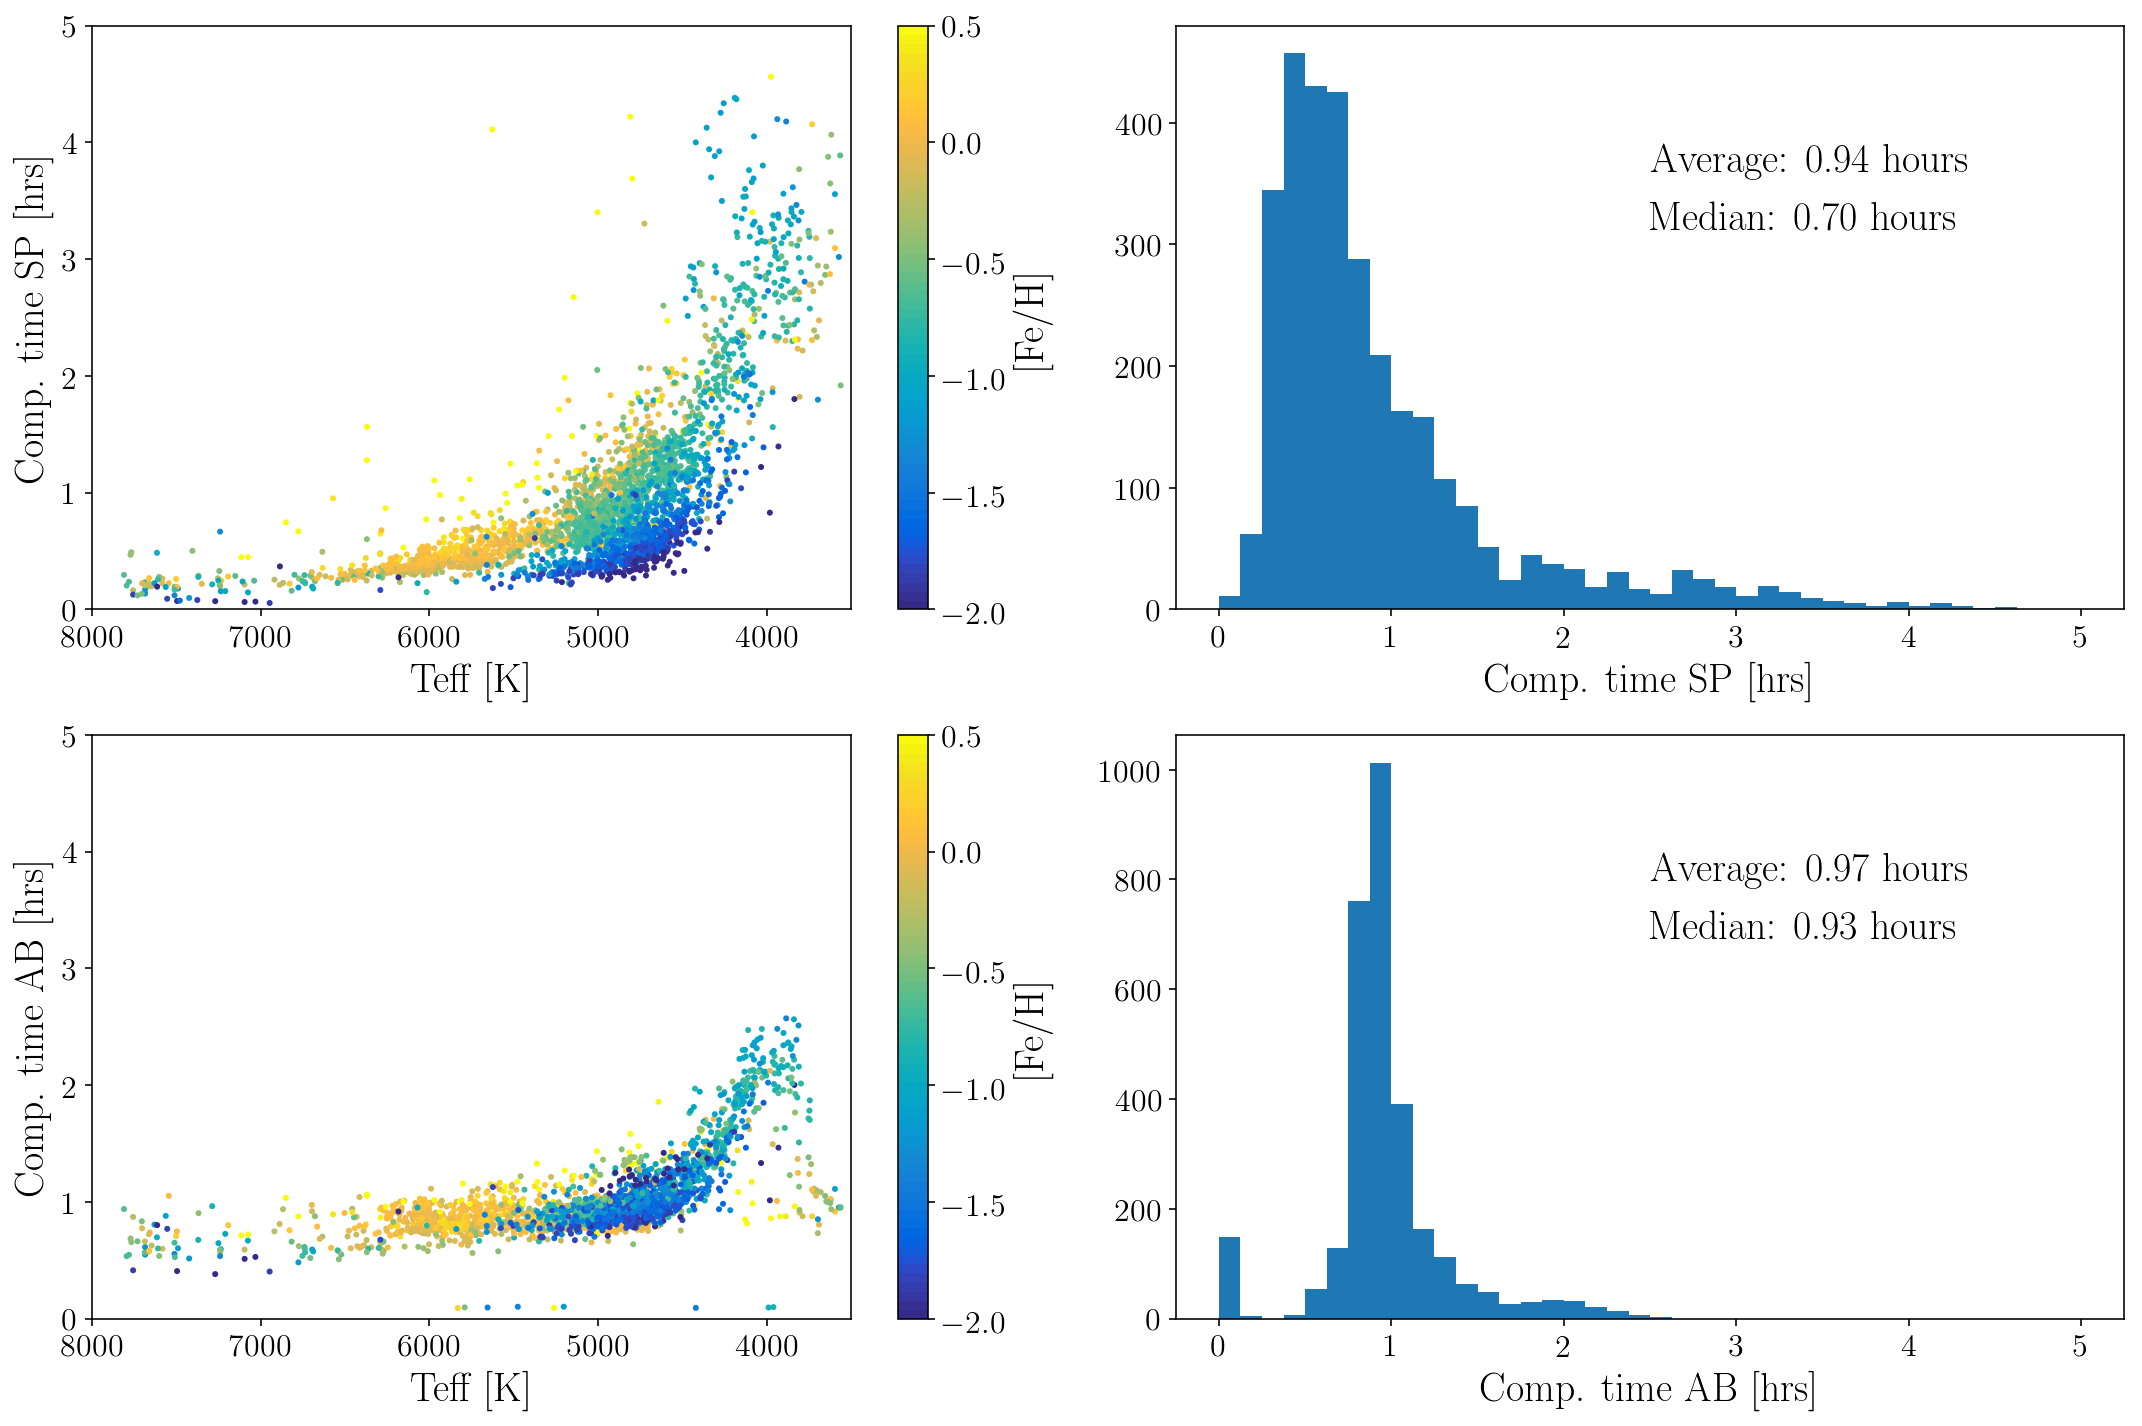

In [65]:
good_time = np.isfinite(sme_all['TIME'][:,0])

f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))
s1 = ax1.scatter(
    sme_all['TEFF'][good_time],
    sme_all['TIME'][good_time,0] / 3600.,
    c = sme_all['FEH'][good_time],
    s = 4, rasterized=True,
    vmin = -2.0, vmax = 0.5,
    cmap = parula)
c1 = plt.colorbar(s1, ax=ax1)
c1.set_label('[Fe/H]')
ax1.set_xlim(8000,3500)
ax1.set_xlabel('Teff [K]')
ax1.set_ylim(0,5)
ax1.set_ylabel('Comp. time SP [hrs]')

ax2.hist(
    sme_all['TIME'][good_time,0] / 3600.,
    bins=np.arange(0,5.1,0.125)
    )
ax2.set_xlabel('Comp. time SP [hrs]')
ax2.text(0.5,0.75,'Average: '+str('%.2f' % np.mean(sme_all['TIME'][good_time,0] / 3600.))+' hours',transform=ax2.transAxes,fontsize=20)
ax2.text(0.5,0.65,'Median: '+str('%.2f' % np.median(sme_all['TIME'][good_time,0] / 3600.))+' hours',transform=ax2.transAxes,fontsize=20)


ab_time = np.array([np.nansum(sme_all['TIME'][x,1:])/ 3600. for x in range(len(sme_all['TIME']))])
good_time = (np.isfinite(ab_time) & (ab_time < 5) & (ab_time > 0))

s3 = ax3.scatter(
    sme_all['TEFF'][good_time],
    ab_time[good_time],
    c = sme_all['FEH'][good_time],
    s = 4, rasterized=True,
    vmin = -2.0, vmax = 0.5,
    cmap = parula)
c3 = plt.colorbar(s3, ax=ax3)
c3.set_label('[Fe/H]')
ax3.set_xlim(8000,3500)
ax3.set_xlabel('Teff [K]')
ax3.set_ylim(0,5)
ax3.set_ylabel('Comp. time AB [hrs]')

ax4.hist(
    ab_time[good_time],
    bins=np.arange(0,5.1,0.125)
    )
ax4.set_xlabel('Comp. time AB [hrs]')
ax4.text(0.5,0.75,'Average: '+str('%.2f' % np.mean(ab_time[good_time]))+' hours',transform=ax4.transAxes,fontsize=20)
ax4.text(0.5,0.65,'Median: '+str('%.2f' % np.median(ab_time[good_time]))+' hours',transform=ax4.transAxes,fontsize=20)

plt.tight_layout()
plt.savefig('figures/computational_costs.png',dpi=300,bbox_inches='tight')
plt.savefig('figures/computational_costs.pdf',dpi=300,bbox_inches='tight')